****Sentiment Analysis in Twitter****

EDA, preprocessing and test evaluation included.

Models used:

Logistic Regression
TextBlob
Neural Network (Pytorch Lightning)

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# load the data
data = pd.read_csv('Y://National College of Ireland//Personal Projects//Sentiment Analysis on Twitter data using Python//twitter_dataset//twitter_training.csv', header=None)
val_data = pd.read_csv('Y://National College of Ireland//Personal Projects//Sentiment Analysis on Twitter data using Python//twitter_dataset//twitter_validation.csv', header=None)

In [6]:
data

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [7]:
val_data

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [8]:
# columns names
data.columns = ['#', 'refers to', 'sentiment', 'text']
val_data.columns = data.columns

In [9]:
# global names
TARGET = 'sentiment'

**EDA**

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   #          74682 non-null  int64 
 1   refers to  74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [12]:
#Checking Null Values

data.isnull().sum()

#              0
refers to      0
sentiment      0
text         686
dtype: int64

In [13]:
val_data.isnull().sum()

#            0
refers to    0
sentiment    0
text         0
dtype: int64

There are 686 samples with no text. As text information is crutial for us, we are going to remove these samples for both EDA anf models fitting.

In [14]:
# drop samples with nans
data.dropna(inplace=True, axis=0)

**Text Stats**

In [15]:
texts = data['text']

In [16]:
text_lens = [len(t.split()) for t in texts.values]
len_mean = np.mean(text_lens)

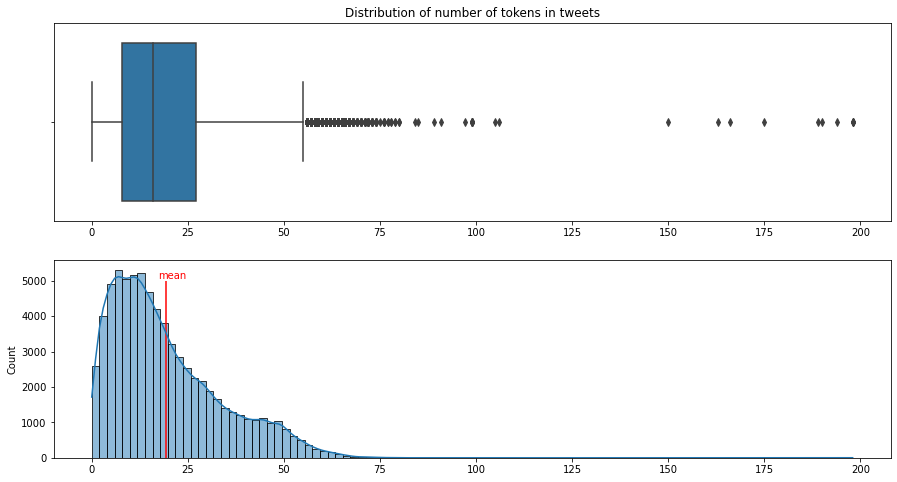

In [17]:
#Plots

fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes[0].set_title('Distribution of number of tokens in tweets')
sns.boxplot(text_lens, ax=axes[0])
sns.histplot(text_lens, bins=100, kde=True, ax=axes[1])
axes[1].vlines(len_mean, 0, 5000, color = 'r')
plt.annotate("mean", xy=(len_mean, 5000), xytext=(len_mean-2, 5050),
            color='r')
plt.show()

Mean length of tweets is nearly 23 tokens. The distribution is scewed positively and a few outliers are observed on the right tail. Some of them are clode to the right whisker but some are located far from the majority of points. Let investigate them!

In [18]:
extreme_outliers = data['text'][np.array(text_lens) > 125]

In [19]:
for idx in extreme_outliers.index:
    print(idx, 'Target', data[TARGET][idx])
    print(extreme_outliers[idx])
    print('=-=-=-=-=-=-=-=-'*4, '\n')

1826 Target Neutral
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 

8546 Target Positive
I REALLY HAVE THE OVERWATCH RN GAME. SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEE E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 

10454 Target Positive
_ _ _ _ _ _ 

It interesting how tweets like "######..." become Nagative labeled. Some of these tweets do not contain any textual information. Such precendents could be removed. Some have both meaningful part and plenty of punctuation characters. They could be removed on the preprocessing stage.

Lets investigate outliers points which are closer to the majotiry.

In [20]:
outliers = data['text'][np.array(text_lens) > 60]

In [21]:
for idx in outliers.index:
    print(idx, 'Target', data[TARGET][idx])
    print(outliers[idx])
    print('=-=-=-=-=-=-=-=-'*4, '\n')

124 Target Positive
Finally played through borderlands 3. The actual game I play is great. Almost all guns feel fun, and yet I never once felt much like someone I seriously needed to grind. That pretty story on the other side hand.... All I will say Is that I'm very damn much so forward looking forward to the eventual endless cutscene skip : )
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 

268 Target Irrelevant
4 My favorite games of all time. ( thanks @317Slayer and @Drunk_Cookies! ).. 1. Halo Wars 2 / PlayStation 3 can't even pick. 2 2. New Rocket League. 3. Kingdom Hearts 2. 4. Super Mario Bros All Stars ( this was probably the first game I ever even played ).. @Demintele_Sway... @DiscoSpider93 @Void_BWungus @LSTesports If let ’ s really see em!
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 

334 Target Neutral
Lee Hey borderlands mutuals fam, sorry I've not been interacting as directly and or playing games as fun much as I had really been but 

65038 Target Negative
@EASPORTS @EAMaddenNFL Fuckk the LGBT advocacy faction at our EA. Those are the ones that benefit the most without ever walking in like those pride park parades. Respect has to get THEM but not these homo - Christ bashing disgusting gay abusers. Fuckk you. ( L ) ove ( I G ) od ( B ) z less ( T ) i rump. @realDonaldTrump
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 

65164 Target Negative
All Disappointing that I can ’ v t play through the special 10 hour EA Play trial show for @EAMaddenNFL. Every year time... I start the game, it says the real EA servers are not available at dinner this time. I ’ ve been buying Madden every year almost for as long as I can remember, but I might be forced to pass this year. Unfortunate.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 

65296 Target Neutral
@EAMaddenNFL I ’ ve owned every madden game since 2003 and this year sucks. The poor defenders are reaction time is handicapped and the runni

Some quick notes:

Most of the tweets seem to be meaningful
I am concerned about the tweets with repeat words. For instance, I've met a few tweets which containe repeated "Italy"

**Target Analysis**

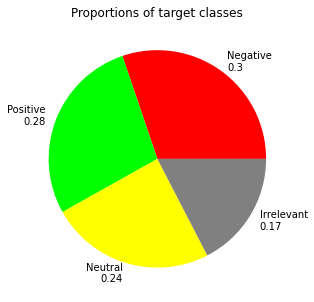

In [22]:
# balance
target_balance = data[TARGET].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(target_balance, labels=[f'{idx}\n{round(target_balance[idx]/len(data), 2)}' for idx in target_balance.index], 
        colors=['r', '#00FF00', '#FFFF00', 'gray'])
plt.title('Proportions of target classes')
plt.show()

In [ ]:
Target categories are almost of equal size, so resampling is not required.

In [23]:
# top words
import re
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')

word_counts = {'Positive': [],
                'Neutral': [],
                'Irrelevant': [],
                'Negative': []}

pattern = re.compile('[^\w ]')
for text, t in zip(data['text'], data[TARGET]):
    text = re.sub(pattern, '', text).lower().split()
    text = [word for word in text if word not in stopwords_list]
    word_counts[t].extend(text)


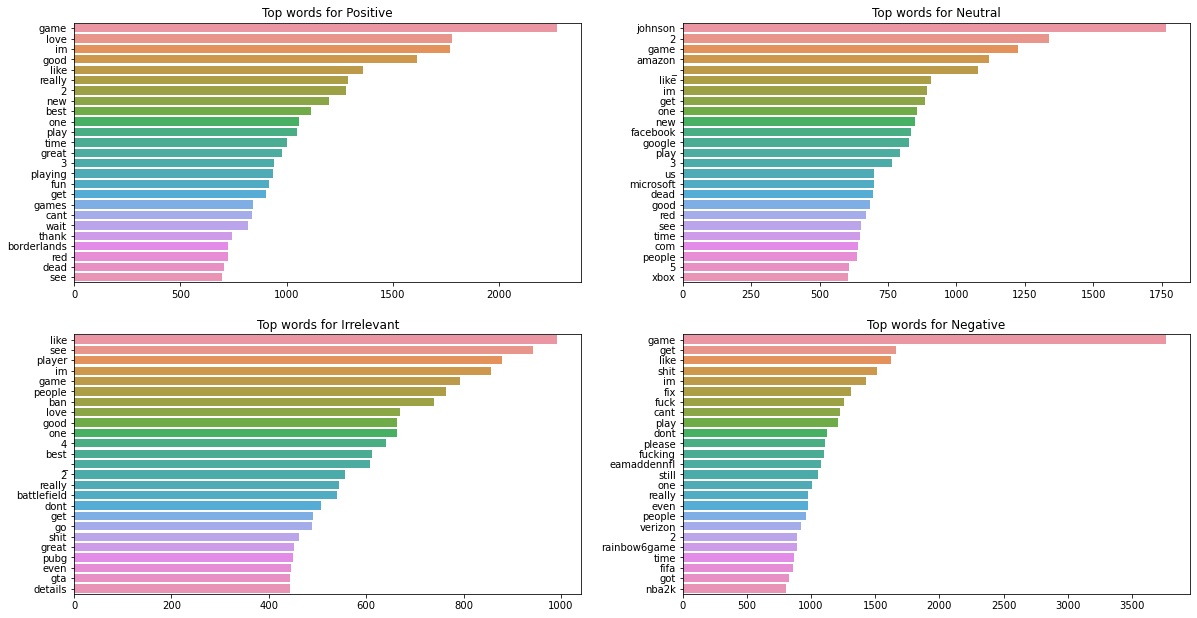

In [24]:
#Plots

fig, axes = plt.subplots(2, 2, figsize=(20,10.5))
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {target}')
plt.show()

We can see a clear difference between emotinal and neutral topics. In "Positive" top we can see some positive words, like love, good, best, great. In "Negative", instead, we observe lots of swear words. In neutral categories words with positive connotation are also observed, but not so frequent. To sum up, distribution of top-frequent words is different across target categories.

Now, lets see most correlated words for each topic using chi2.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english',
                        max_features=10000)


features = tfidf.fit_transform(data['text']).toarray()

labels = data[TARGET]

print("Each of the %d Text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 73996 Text is represented by 10000 features (TF-IDF score of unigrams and bigrams)


In [26]:
from sklearn.feature_selection import chi2
N = 10
for label in set(labels):
    features_chi2 = chi2(features, labels == label)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(label))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Neutral:
  * Most Correlated Unigrams are: tt, dlvr, 2020, check, com, amazon, achievement, earned, https, johnson
  * Most Correlated Bigrams are: twitch tv, johnson stop, stop selling, ift tt, watch video, check video, johnson johnson, chance win, com 2020, just earned

==> Negative:
  * Most Correlated Unigrams are: sucks, love, shit, rainbow6game, wtf, servers, nba2k, fuck, eamaddennfl, fix
  * Most Correlated Bigrams are: details bf4db, red dead, bf4db com, player ban, com player, fix servers, eamaddennfl fix, rainbow6game fix, fix game, twitch tv

==> Irrelevant:
  * Most Correlated Unigrams are: battlefield, montage, eamaddennfl, verizon, johnson, details, occurred, ban, bf4db, player
  * Most Correlated Bigrams are: johnson johnson, home depot, ban 100, ban battlefield, battlefield player, occurred details, details bf4db, bf4db com, com player, player ban

==> Positive:
  * Most Correlated Unigrams are: good, amazing, thank, creed, nice, excited, fun, wow, wait, love
  * M

In [27]:
# len for classes without outliers
tweets_len = {'Positive': [],
                'Neutral': [],
                'Irrelevant': [],
                'Negative': []}
pattern = re.compile('[^\w ]')
tweets_len = pd.DataFrame([len(re.sub(pattern, '', text).lower().split()) for text in data['text'] if len(text)< 125],
                         columns=['len'])

In [28]:
tweets_len['target'] = data[TARGET]

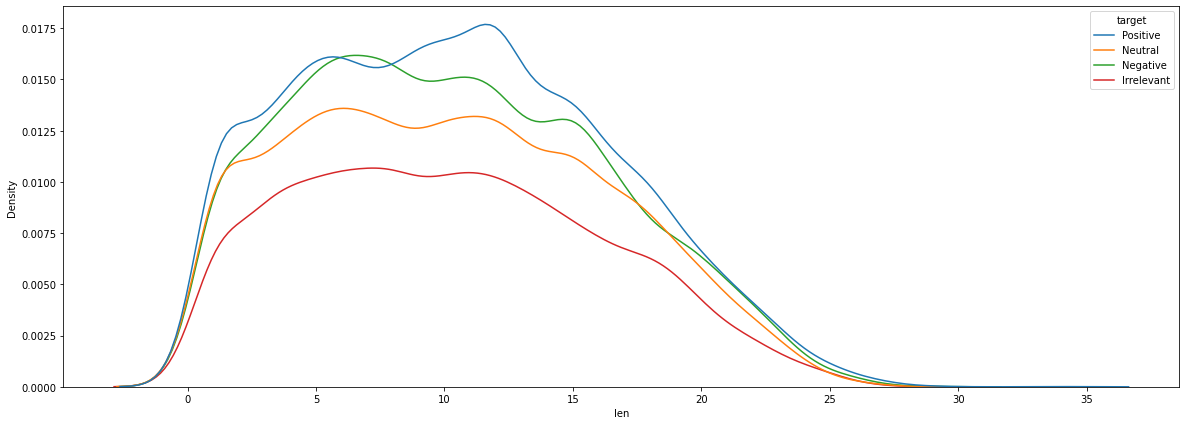

In [29]:
plt.figure(figsize=(20, 7))
sns.kdeplot(data=tweets_len, x='len', hue='target')
plt.show()

Distributions of tweets length do not differ from each other. We can ensure using ANOVA test as we have equal dispesion and normal-like distribution.

In [36]:

import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import statsmodels.api as sm

from statsmodels.formula.api import ols

#perform two-way ANOVA
model = ols('len ~ target', data=tweets_len).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
target,2.121388e+02,3.0,2.010766,0.110064
Residual,1.696464e+06,48240.0,NaN,NaN


In [42]:
#!pip install emoji

# emoticons
import emoji
import regex as re

def split_count(text):
    emoji_list = []
    data = re.findall(r'\X', text)
    for word in data:
        if any(char in emoji.distinct_emoji_list(word) for char in word):
            emoji_list.append(word)
    
    return emoji_list

In [43]:
target_emojis = {'Positive': [],
                'Neutral': [],
                'Irrelevant': [],
                'Negative': []}

pattern = re.compile('\u200d')
for i, text in enumerate(texts):
    emoji_count = split_count(text)
    if emoji_count:
        emoji_count = [re.sub(pattern, '', e) for e in emoji_count]
        target_emojis[data[TARGET].iloc[i]].extend(emoji_count)

Top emojis for Positive 
 ['🤣', '🥰', '🥺', '🤔', '🤩', '™', '🥳', '🦁', '🤯', '‼', '🤖', '🤤', '🥴', '🤷', '🤦', '🥵', '🤞', '🤸', '🦊', '🧡']


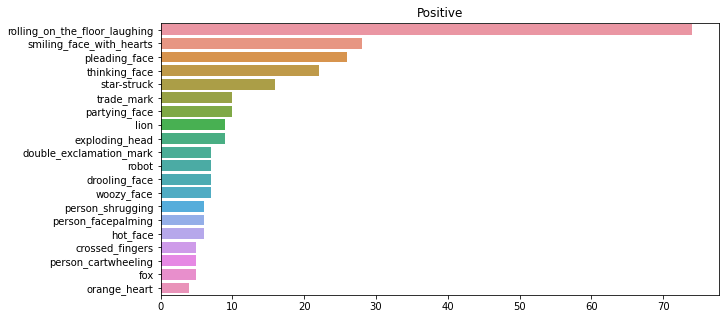

Top emojis for Neutral 
 ['🤣', '🤔', '🤦', '🥺', '™', '©', '🤩', '🥰', '‼', '🤯', '🤠', '🥳', '🤡', '🤨', '🤬', '🤷', '🧐', '🧨', '🥴', '🤳']


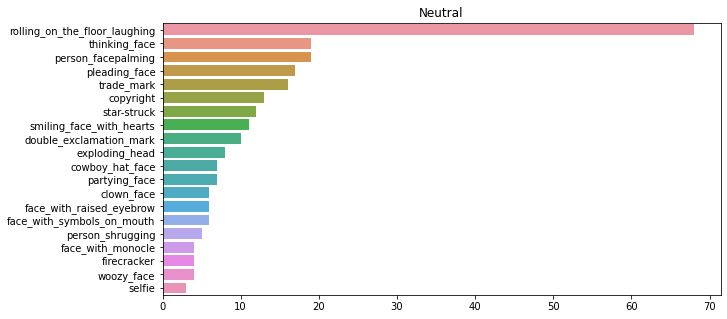

Top emojis for Irrelevant 
 ['🤣', '🥺', '🥰', '🤔', '🥳', '🤗', '🥴', '🤪', '🤦', '🤷', '🧘', '🤓', '🤧', '🤬', '🦋', '🤢', '🤡', '‼', '🤐', '🤮']


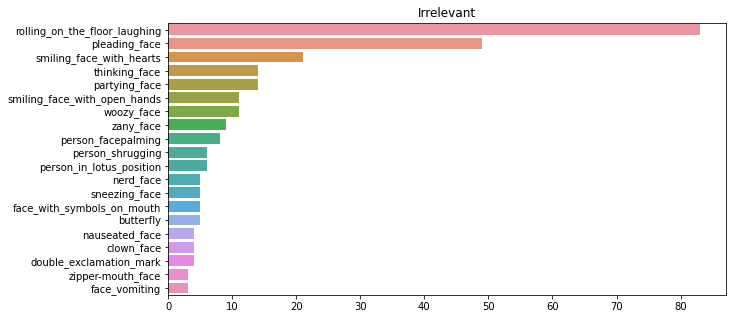

Top emojis for Negative 
 ['🤣', '🤦', '🥺', '🤬', '🥴', '🤷', '🤔', '™', '🧢', '🤡', '🤢', '🤩', '🤑', '‼', '🤪', '©', '🥰', '🤨', '🤓', '🤟']


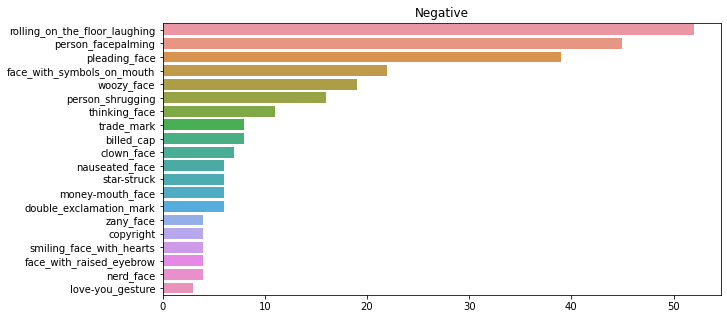

In [44]:
for t, emojis in target_emojis.items():
    plt.figure(figsize=(10, 5))
    bar_info = pd.Series(emojis).value_counts()[:20]
    print('=========='*10,  f'\nTop emojis for {t} \n', list(bar_info.index))
    bar_info.index = [emoji.demojize(i, delimiters=("", "")) for i in bar_info.index]
    sns.barplot(x=bar_info.values, y=bar_info.index)
        
    plt.title(f'{t}')
    plt.show()

As we can see, the most popular emoji across al the classes is rolling_on_the_floor_laughing except Negative. Here, person_facepalming is on the 1st place. For Positive class, for instance, it is on the 4th. Also, all other emoticons have different distribution across the taget cetegories. Also, It is noticeable that the gap between the most popular (rolling_on_the_floor_laughing) and the second popular emoticons is different and is the smallest for Negative class.

Negative class also contains some negative emojis like 🤬, 🥴, 🤷 which do not occur in other categories.

In [45]:
# capitalization distribution
capitalized = [np.sum([t.isupper() for t in text.split()]) for text in np.array(data['text'])]

In [46]:
capitalized_target = pd.DataFrame([(c, t) for c, t in zip(capitalized, data[TARGET])], columns=['cap', 'target'])

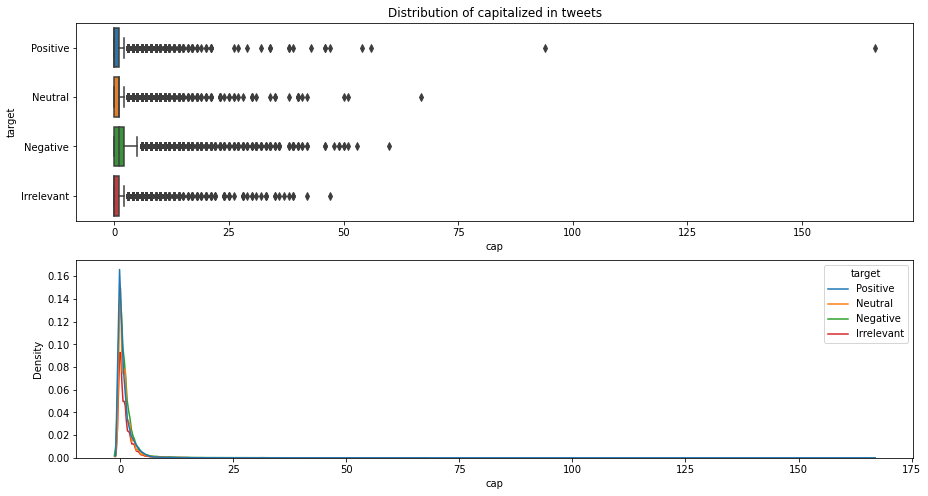

In [47]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes[0].set_title('Distribution of capitalized in tweets')
sns.boxplot(x=capitalized_target['cap'], y=capitalized_target['target'], ax=axes[0])

sns.kdeplot(data=capitalized_target, x='cap', hue='target', ax=axes[1])
plt.show()

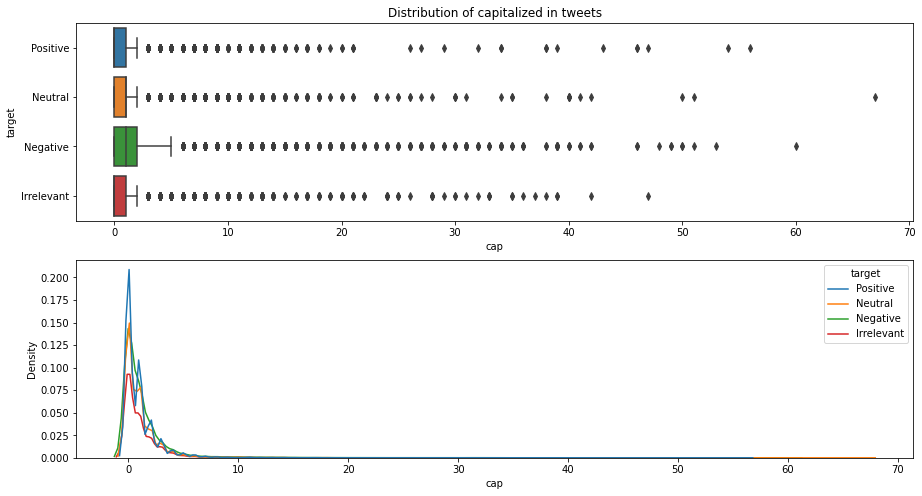

In [48]:
# closer look
capitalized_target_no_outliers = capitalized_target[capitalized_target['cap'] < 75]
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes[0].set_title('Distribution of capitalized in tweets')
sns.boxplot(x=capitalized_target_no_outliers['cap'], y=capitalized_target['target'], ax=axes[0])

sns.kdeplot(data=capitalized_target_no_outliers, x='cap', hue='target', ax=axes[1])
plt.show()

Text(0.5, 1.0, 'Frequencies of meeting referred objects in each category')

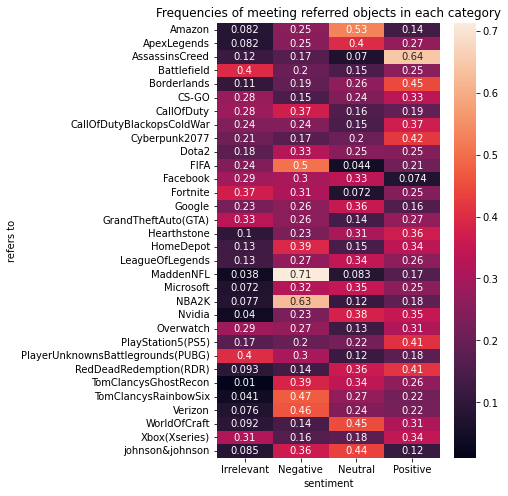

In [49]:
plt.figure(figsize=(5, 8))
sns.heatmap(pd.crosstab(data['refers to'], data[TARGET], normalize='index'), annot=True)
plt.title('Frequencies of meeting referred objects in each category')

**Preprocessing**

Sentiment information is mostly expressed on the lexical and punctuational levels. For internet discourse we can also use emoticons as their main purpose is to represent emotions which are our target.

Thus, syntactic relations are not really important to us. As well as semantic features of words. So, we can use simple tf-idf encoders in which we also enclude punctuation (mostly exclamation and question marks), case (CapsLoc as a signal of strong emotions) and emojis.

Required preparation steps:

lowercase words, but count for each text how many characters or words we capitalized.
remove stopwords and numbers as sentiment neutral
decode emojis
lemmatize
vectorize with tf-idf.
Add refers to feature ohe
delete nans
Additionally perform feature selection with chi2

In [76]:
#!python -m spacy download en_core_web_sm
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

import spacy
!python -m spacy download en_core_web_sm 
from spacy import displacy
    
nlp = spacy.load("en_core_web_sm")


from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en import English
import emoji
import spacy
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.exceptions import NotFittedError

import re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
#nlp = spacy.load("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.0
    Uninstalling en-core-web-sm-2.2.0:
      Successfully uninstalled en-core-web-sm-2.2.0
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2022-08-21 00:07:27.267342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-08-21 00:07:27.267401: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yogiraj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [77]:
ids_to_remove = [1826, 10454, 32186, 68078]
data = data[~data.index.isin(ids_to_remove)]
data.index = range(len(data))

In [78]:
class Preprocessor:
    def __init__(self, stopwords=stopwords):
        self.vectorizer = TfidfVectorizer(lowercase=False, max_features=8000,
                                         min_df=10, ngram_range=(1, 3),
                                         tokenizer=None)
        self.stopwords = stopwords
        self.vectorizer_fitted = False
        
    def remove_urls(self, texts):
        print('Removing URLs...')
        pattern = re.compile('(\w+\.com ?/ ?.+)|(http\S+)')
        return [re.sub(pattern, '', text) for text in texts]
    
    def remove_double_space(self, texts):
        print('Removing double space...')
        pattern = re.compile(' +')
        return [re.sub(pattern, ' ', text) for text in texts]
        
    def remove_punctuation(self, texts):
        print('Removing Punctuation...')
        pattern = re.compile('[^a-z ]')
        return [re.sub(pattern, ' ', text) for text in texts]
    
    def remove_stopwords(self, texts):
        print('Removing stopwords...')
        return [[w for w in text.split(' ') if w not in self.stopwords] for text in tqdm(texts)]
    
    def remove_numbers(self, texts):
        print('Removing numbers...')
        return [' '.join([w for w in text if not w.isdigit()]) for text in tqdm(texts)]
    
    def decode_emojis(self, texts):
        print('Decoding emojis...')
        return [emoji.demojize(text, language='en') for text in texts] 
    
    def lemmatize(self, texts):
        print('Lemmatizing...')
        lemmatized_texts = []
        for text in tqdm(texts):
            doc = nlp(text)
            lemmatized_texts.append(' '.join([token.lemma_ for token in doc]))
                                    
        return lemmatized_texts
        
    def transform(self, X, y=None, mode='train'):
        X = X.copy()
        print('Removing Nans...')
        X = X[~X.isnull()]                          # delete nans
        X = X[~X.duplicated()]                      # delete duplicates
        
        if mode == 'train':
            self.train_idx = X.index
        else:
            self.test_idx = X.index
        print('Counting capitalized...')
        capitalized = [np.sum([t.isupper() for t in text.split()]) 
                           for text in np.array(X.values)]  # count capitalized
        # X['cap'] = capitalized
        print('Lowering...')
        X = [text.lower() for text in X]             # lower
        X = self.remove_urls(X)                      # remove urls
        X = self.remove_punctuation(X)               # remove punctuation
        X = self.remove_double_space(X)              # remove double space
        X = self.decode_emojis(X)                    # decode emojis
        X = self.remove_stopwords(X)                 # remove stopwords
        X = self.remove_numbers(X)                   # remove numbers                      
        X = self.lemmatize(X)                        # lemmatize
        
        if not self.vectorizer_fitted:
            self.vectorizer_fitted = True
            print('Fitting vectorizer...')
            self.vectorizer.fit(X)

        print('Vectorizing...')
        X = self.vectorizer.transform(X)             # vectorize
        
        return X

In [79]:
pr = Preprocessor()

In [80]:
data_train = data
data_test = val_data

y_train = data['sentiment']
y_test = val_data['sentiment']

In [81]:
data_train_pr = pr.transform(data_train['text'])
data_train_pr = pd.DataFrame.sparse.from_spmatrix(data_train_pr, columns=pr.vectorizer.get_feature_names_out())

ohe = OneHotEncoder()
referring_ohe = ohe.fit_transform(data_train['refers to'][data_train.index.isin(pr.train_idx)].to_numpy().reshape(-1, 1))
referring_ohe = pd.DataFrame.sparse.from_spmatrix(referring_ohe, columns=ohe.get_feature_names_out())

X_train = pd.concat([data_train_pr, referring_ohe], axis=1)
y_train = y_train[y_train.index.isin(pr.train_idx)]
y_train.index = X_train.index

Removing Nans...
Counting capitalized...
Lowering...
Removing URLs...
Removing Punctuation...
Removing double space...
Decoding emojis...
Removing stopwords...


100%|████████████████████████████████████████████████████████████████████████| 69481/69481 [00:00<00:00, 128700.69it/s]


Removing numbers...


100%|████████████████████████████████████████████████████████████████████████| 69481/69481 [00:00<00:00, 544546.56it/s]


Lemmatizing...


100%|███████████████████████████████████████████████████████████████████████████| 69481/69481 [06:35<00:00, 175.56it/s]


Fitting vectorizer...
Vectorizing...


In [82]:
data_test_pr = pr.transform(data_test['text'], mode='test')
data_test_pr = pd.DataFrame.sparse.from_spmatrix(data_test_pr, columns=pr.vectorizer.get_feature_names_out())

ohe = OneHotEncoder()
referring_ohe = ohe.fit_transform(data_train['refers to'][data_train.index.isin(pr.train_idx)].to_numpy().reshape(-1, 1))
referring_ohe = ohe.transform(data_test['refers to'][data_test.index.isin(pr.test_idx)].to_numpy().reshape(-1, 1))
referring_ohe = pd.DataFrame.sparse.from_spmatrix(referring_ohe, columns=ohe.get_feature_names_out())

X_test = pd.concat([data_test_pr, referring_ohe], axis=1)
y_test = y_test[y_test.index.isin(pr.test_idx)]
y_test.index = X_test.index

Removing Nans...
Counting capitalized...
Lowering...
Removing URLs...
Removing Punctuation...
Removing double space...
Decoding emojis...
Removing stopwords...


100%|████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 199785.90it/s]


Removing numbers...


100%|████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 333368.58it/s]


Lemmatizing...


100%|███████████████████████████████████████████████████████████████████████████████| 999/999 [00:06<00:00, 165.29it/s]


Vectorizing...


In [83]:
X_test.shape, y_test.shape

((999, 8032), (999,))

In [84]:
# save prepared data for the future

with open('../X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('../X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)

with open('../y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('../y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

**Training**

In [87]:
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix

In [88]:
def train_cv(model, X_train, y_train, params, n_splits=5, scoring='f1_weighted'):
    kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)

    cv = RandomizedSearchCV(model,
                        params,
                        cv=kf,
                        scoring=scoring,
                        return_train_score=True,
                        n_jobs=-1,
                        verbose=2,
                        random_state=1
                        )
    cv.fit(X_train, y_train)

    print('Best params', cv.best_params_)
    return cv

In [89]:
rs_parameters = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'C': uniform(scale=10),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
    'l1_ratio': uniform(scale=10)
    }

1. Without feature selection
2. MI feature selection

**Training without feature selection**

In [91]:
lr = LogisticRegression()
model_cv_lr = train_cv(lr, X_train, y_train, rs_parameters)

bestimator_lr = model_cv_lr.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params {'C': 9.13962024579233, 'l1_ratio': 4.572048079869883, 'penalty': 'l1', 'solver': 'saga'}


In [92]:
print(classification_report(y_test, bestimator_lr.predict(X_test)))

              precision    recall  f1-score   support

  Irrelevant       0.89      0.90      0.89       172
    Negative       0.92      0.93      0.92       266
     Neutral       0.93      0.91      0.92       285
    Positive       0.91      0.91      0.91       276

    accuracy                           0.91       999
   macro avg       0.91      0.91      0.91       999
weighted avg       0.91      0.91      0.91       999



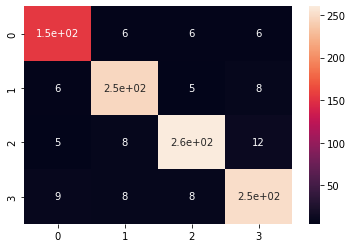

In [93]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, bestimator_lr.predict(X_test)), annot=True)
plt.show()

Pretty descend score for a baseline. All classes are predicted almost equally good, confusion matrix look diagonal.

Let's look if we could get the same score after droping some the least important features according to Mutual Information score.

**With MI feature selection**

In [94]:
from sklearn.feature_selection import mutual_info_classif as MIC
mi_score = MIC(X_train,y_train)

In [95]:
cols_importance = sorted(list(zip(X_train.columns, mi_score)), key=lambda x: x[1], reverse=True)

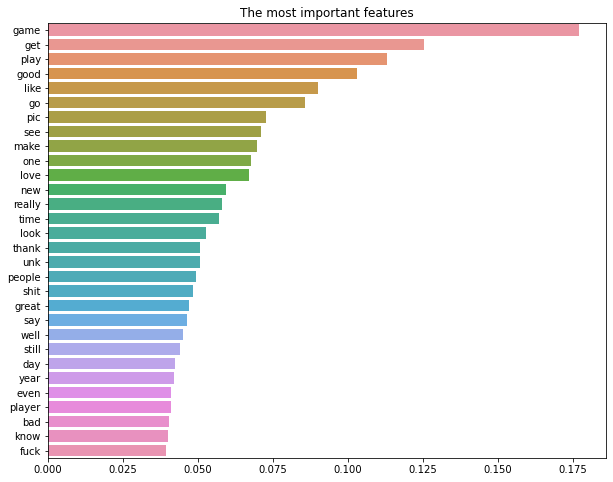

In [96]:
plt.figure(figsize=(10, 8))
mi_imp = [pair[1] for pair in cols_importance[:30]]
cols = [pair[0] for pair in cols_importance[:30]]
sns.barplot(x=mi_imp, y=cols)
plt.title('The most important features')
plt.show()

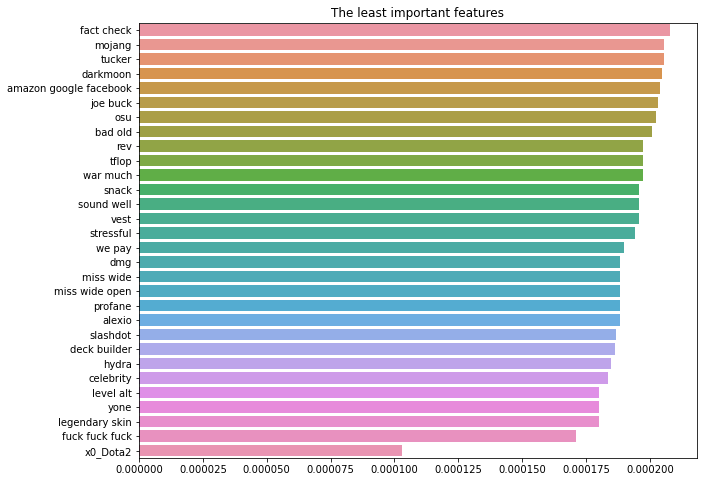

In [97]:
plt.figure(figsize=(10, 8))
mi_imp = [pair[1] for pair in cols_importance[-30:]]
cols = [pair[0] for pair in cols_importance[-30:]]
sns.barplot(x=mi_imp, y=cols)
plt.title('The least important features')
plt.show()

In [98]:
X_train_6k = X_train[[pair[0] for pair in cols_importance[:6000]]]
X_test_6k = X_test[[pair[0] for pair in cols_importance[:6000]]]

In [99]:
# leave 6k features
lr = LogisticRegression()
model_cv_lr_6k = train_cv(lr, X_train_6k, y_train, rs_parameters)

bestimator_lr_6k = model_cv_lr_6k.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params {'C': 9.13962024579233, 'l1_ratio': 4.572048079869883, 'penalty': 'l1', 'solver': 'saga'}


In [100]:
print(classification_report(y_test, bestimator_lr_6k.predict(X_test_6k)))

              precision    recall  f1-score   support

  Irrelevant       0.88      0.85      0.87       172
    Negative       0.87      0.90      0.89       266
     Neutral       0.88      0.85      0.86       285
    Positive       0.85      0.87      0.86       276

    accuracy                           0.87       999
   macro avg       0.87      0.87      0.87       999
weighted avg       0.87      0.87      0.87       999



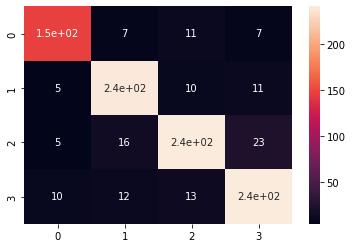

In [101]:
sns.heatmap(confusion_matrix(y_test, bestimator_lr_6k.predict(X_test_6k)), annot=True)
plt.show()

The scores dropped, but not dramatically. The confusion matrix is still diagonal.

To sum up, with 75% of features we can obtain 97% of baseline accuracy with every feature.

**Binary Classification + Textblob sentiment analysis**

Textblob.sentiment is a pretrained instrument which return the polarity and subjectivity of a text.

In the task, we need not only predict sentiment, but also detect irrelevant messages.

In this section, I created a SentimntClassifier which contains a Logistic regression for binary classification: relevant and irrelevant messages. Then relevant texts are passed to textblob.sentiment for polarity estimating.

In [102]:
from textblob import TextBlob

class SentimentClassifier:
    def __init__(self):
        self.classifier = LogisticRegression()
    
    def fit_classifier(self, X_vector, y, params):
        model_cv = self.classifier.fit(X_vector, y)
        self.classifier = model_cv#.best_estimator_
        
    def __return_label(self, polarity):
        if -1. <= polarity < 0:
            return 'Negative'
        if polarity == 0:
            return 'Neutral'
        return 'Positive'
        
    def predict_sentiment(self, X_vector, X_texts):
        irrelevance = self.classifier.predict(X_vector)
        X_sentimental = X_texts[irrelevance == 0]
        X_sentimental_idx = X_sentimental.index
        X_irrelevant_index = X_vector[irrelevance == 1].index
        
        pred_sent = [TextBlob(text).sentiment.polarity for text in X_sentimental]
        pred_sent = pd.Series([*map(lambda x: self.__return_label(x), pred_sent )],
                              index=X_sentimental_idx)
        
        pred_irrelevance = irrelevance[irrelevance == 1]
        pred_irrelevance = pd.Series(pred_irrelevance, index=X_irrelevant_index)
        pred_irrelevance = pred_irrelevance.apply(lambda x: 'Irrelevant')
        
        pred = pd.concat([pred_irrelevance, pred_sent], axis=0).sort_index(inplace=False)
        
        return pred

In [104]:
sent_classifier = SentimentClassifier()

sent_classifier.fit_classifier(X_train_6k, 
                               [1 if target == 'Irrelevant' else 0 for target in y_train], 
                               rs_parameters)

X_texts_test = data['text'][data.index.isin(X_test.index)]

In [105]:
pred_test = sent_classifier.predict_sentiment(X_test_5k, X_texts_test)
pred_test.value_counts()

Positive      492
Negative      222
Neutral       178
Irrelevant    107
dtype: int64

In [137]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

  Irrelevant       0.89      0.55      0.68       172
    Negative       0.34      0.28      0.31       266
     Neutral       0.33      0.20      0.25       285
    Positive       0.30      0.53      0.38       276

    accuracy                           0.38       999
   macro avg       0.46      0.39      0.41       999
weighted avg       0.42      0.38      0.38       999



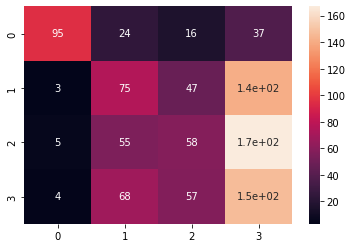

In [138]:
sns.heatmap(confusion_matrix(y_test, pred_test), annot=True)
plt.show()

TextBlob seems to cope poorly with the given task. Meanwhile, not optimized logistic regression managed to classify massages much better than textblob classified later relevant ones.

The confusion matrix is a mess. All classes are mostly detected as the Positive one.

I consider this experiment as a fail and I am not intended to optimize it later.

**Conclusion**

In this notebook several experiments were condated implementing the following models:

Logistic Regression
Logistic Regression + feature selection
Binary Logistic Regression + TextBlob

Logistic Regression baseline showed the best results (91% accuracy), Feature selection allowed to decrease number of features from 8032 to 6000 keeping more than 95% performance (88% accuracy compared to 91%).

TextBlob pretrained model was not successfull on this task.
